In [1]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [34]:
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

- Google Drive Mount

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.xlsx'

-rw------- 1 root root 23715344 Mar  7 07:08 '/content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.xlsx'


In [6]:
DF = pd.read_excel('/content/drive/My Drive/Colab Notebooks/datasets/Online_Retail.xlsx')

##1. 탐색적데이터분석

- InvoiceNo: 주문번호, 'C' 시작은 주문취소
- StockCode: 제품코드(Item Code)
- Description: 제품설명
- Quantity: 주문건수
- InvoiceDate: 주문날짜
- UnitPrice: 제품단가
- CustomerID: 고객번호
- Country: 국가명(주문 고객 국적)

In [7]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [23]:
DF.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 1) 결측치 제거
- 'Quantity', 'UnitPrice', 'CustomerID'

In [8]:
DF = DF[DF['Quantity'] > 0]
DF = DF[DF['UnitPrice'] > 0]
DF = DF[DF['CustomerID'].notnull()]

DF.shape

(397884, 8)

In [9]:
DF.isnull().sum(axis = 0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### 2) 'United Kingdom'만 사용
- 대부분의 구매자가 영국 국적

In [10]:
DF['Country'].value_counts()[:10]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: Country, dtype: int64

- 영국 데이터만 추출

In [11]:
DF = DF[DF['Country'] == 'United Kingdom']

DF.shape

(354321, 8)

## 3. RFM 기반 Data Reengineering
- Recency: 가장 최근 상품 구매일에서 오늘까지 기간
- Frequency: 상품 구매 횟수
- Monetary Value: 총 구매 금액

### 1) 'sale_amount' 추가
- '주문금액' = '주문개수' * '제품가격'

In [12]:
DF['sale_amount'] = DF['Quantity'] * DF['UnitPrice']

In [13]:
DF.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sale_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


- 'CustomerID' 정수변환

In [14]:
DF['CustomerID'] = DF['CustomerID'].astype(int)

### 2) 주문특성 확인
- Top-5 주문건수 'CustomerID'

In [15]:
DF['CustomerID'].value_counts().head()

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64

- Top-5 주문금액 'CustomerID'

In [16]:
DF.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False)[:10]

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
12346     77183.60
16684     66653.56
14096     65164.79
13694     65039.62
15311     60767.90
Name: sale_amount, dtype: float64

- 몇몇 특정 고객이 많은 '주문건수'와 '주문금액'을 가지고 있음

### 3) 'CustomerID' 기준으로 DataFrame 재구성
- Recency: 'InvoiceDate'의 max()
- Frequency: 'InvoiceNo'의 count()
- Monetary Value: 'sale_amount'의 sum()

In [17]:
aggregation = {'InvoiceDate' : 'max' ,
               'InvoiceNo' : 'count' ,
               'sale_amount' : 'sum'}

DF_CID = DF.groupby('CustomerID').agg(aggregation)

In [18]:
DF_CID.head()

,InvoiceDate,InvoiceNo,sale_amount
CustomerID,,,
12346,2011-01-18 10:01:00,1,77183.60
12747,2011-12-07 14:34:00,103,4196.01
12748,2011-12-09 12:20:00,4595,33719.73
12749,2011-12-06 09:56:00,199,4090.88
12820,2011-12-06 15:12:00,59,942.34


- groupby() 결과 Index와 Column 이름 수정
  - 'Recency' , 'Frequency' , 'Monetary'

In [19]:
DF_CID = DF_CID.rename(columns = {'InvoiceDate' : 'Recency' ,
                                  'InvoiceNo' : 'Frequency' ,
                                  'sale_amount' : 'Monetary'})

In [20]:
DF_CID = DF_CID.reset_index()

- RFM 변경 결과

In [21]:
DF_CID.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


### 4) 최근 구매일자 Day로 변경
- 오늘 날짜에서 최근 구매날짜('Recency')를 뺀 일자

In [23]:
DF_CID['Recency'] = dt.datetime(2011, 12, 10) - DF_CID['Recency']

In [26]:
DF_CID['Recency'] = DF_CID['Recency'].apply(lambda x : x.days + 1)

In [27]:
DF_CID.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


### 5) Visualization
- 변수 별 분포 확인

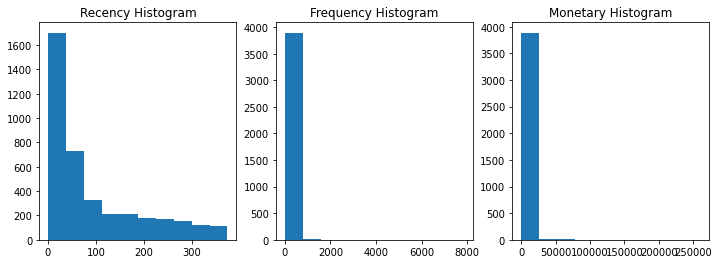

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 4) , nrows = 1, ncols = 3)

ax1.set_title('Recency Histogram')
ax1.hist(DF_CID['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(DF_CID['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(DF_CID['Monetary'])

plt.show()

## 4. K-means Clustering

### 1) Standardization
- 표준화를 통한 평균과 표준편차 Scaling

In [33]:
DF_CID[['Recency' , 'Frequency' , 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


- Scaling 수행

In [36]:
X_input = DF_CID[['Recency' , 'Frequency' , 'Monetary']].values
X_input_scaled = StandardScaler().fit_transform(X_input)

### 2) Modeling


#### (1) K-means

In [37]:
kmeans = KMeans(n_clusters = 5,
                random_state = 2045)

kmeans.fit_predict(X_input_scaled)

array([1, 0, 4, ..., 0, 0, 0], dtype=int32)

- Silhouette Score

In [38]:
silhouette_score(X_input_scaled, kmeans.fit_predict(X_input_scaled))

0.6114742734112578

In [39]:
kmeans.inertia_

2898.825737184124

In [40]:
inertia = []
K = range(1, 10)

for k in K:
  kmeanModel = KMeans(n_clusters = k)
  kmeanModel.fit(X_input_scaled)
  inertia.append(kmeanModel.inertia_)

In [41]:
inertia

[11760.0,
 8504.559256677869,
 5461.264105443646,
 4004.0658186122846,
 2853.751896618272,
 2155.1971167497154,
 1749.733739786736,
 1476.8825650020874,
 1279.8324411163621]

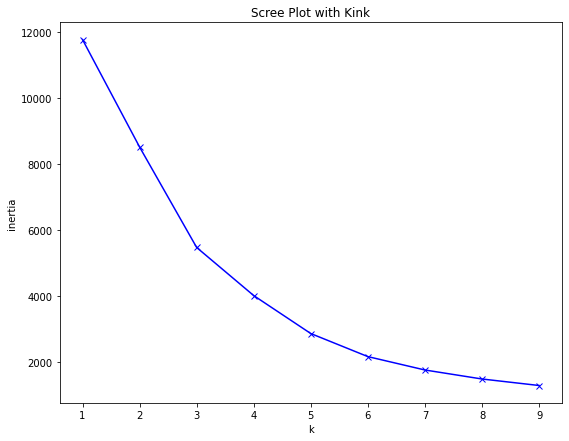

In [42]:
plt.figure(figsize = (9, 7))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Scree Plot with Kink')
plt.show()

#### (2) Mean Shift

In [45]:
meanshift = MeanShift(bandwidth = 1)
meanshift.fit_predict(X_input_scaled)

array([ 7,  0, 23, ...,  0,  1,  0])

In [46]:
meanshift.labels_

array([ 7,  0, 23, ...,  0,  1,  0])

- Silhouette Score

In [47]:
silhouette_score(X_input_scaled, meanshift.fit_predict(X_input_scaled))

0.5209251244700349

#### (3) GMM

In [48]:
gmm = GaussianMixture(n_components = 6,
                      random_state = 2045)
gmm.fit(X_input_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=2045, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [52]:
gmm.predict(X_input_scaled)

array([5, 1, 2, ..., 0, 2, 1])

- Silhouette Score

In [53]:
silhouette_score(X_input_scaled, gmm.predict(X_input_scaled))

0.04755631141782142

#### (4) DBSCAN

In [54]:
dbscan = DBSCAN(eps = 0.8,
                min_samples = 8,
                metric = 'euclidean')

dbscan.fit_predict(X_input_scaled)

array([-1,  0, -1, ...,  0,  0,  0])

- Silhouette Score

In [55]:
silhouette_score(X_input_scaled, dbscan.fit_predict(X_input_scaled))

0.8580550402528754